# Imports

In [1]:
import os
import pickle
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
from torch.nn.functional import normalize
import numpy as np
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
import time  # Optional, to slow down updates a little

# Path Declaration

In [2]:
project_base_path = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
project_base_path

'/home/ANONYMOUS/projects/FALCON'

In [3]:
saved_v1_generated_data_path = os.path.join(project_base_path, "data/generation/yara/yara-rules_v1.pkl")
saved_v1_generated_data_path

'/home/ANONYMOUS/projects/FALCON/data/generation/yara/yara-rules_v1.pkl'

In [4]:
saved_v2_generated_data_path = os.path.join(project_base_path, "data/generation/yara/yara-rules_v2.pkl")
saved_v2_generated_data_path

'/home/ANONYMOUS/projects/FALCON/data/generation/yara/yara-rules_v2.pkl'

# Environment Setup

In [11]:
# ⚙️ Config
MODEL_NAME = "/data/common/models/sentence-transformers/all-MiniLM-L6-v2"
BATCH_SIZE = 70
EPOCHS = 30
LR = 2e-5
MAX_LEN = 512
DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
###########################
RUN = 2
FINE_TUNED_MODEL_NAME = "all-MiniLM-L6-v2"
FINE_TUNED_MODEL_STATE_NAME = f"contrastive_encoder_r{RUN}.pt"
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
        
MODEL_SAVE_PATH = os.path.join(project_base_path, f"script/fine_tuning/bi-encoder/yara/{FINE_TUNED_MODEL_NAME}/{FINE_TUNED_MODEL_STATE_NAME}")

# Load Dataset

In [12]:
def load_from_pickle(file_path) -> dict:
    """
    Loads data from a pickle file.

    :param file_path: Path to the pickle file
    :return: Loaded data
    """
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except Exception as e:
        print(f"Error loading data from pickle: {e}")
        return None

In [13]:
def get_first_n_elements(dictionary: dict, n: int) -> dict:
    """
    Get the first n elements of a dictionary.

    :param dictionary: The input dictionary
    :param n: The number of elements to retrieve
    :return: A dictionary with the first n elements
    """
    return dict(list(dictionary.items())[:n])

In [14]:
# Load the data back from the pickle file
loaded_v1_data = load_from_pickle(saved_v1_generated_data_path)
print(len(loaded_v1_data.keys()))

4588


In [15]:
yara_cti_sample_dict = get_first_n_elements(loaded_v1_data, 10)

In [16]:
# Load the data back from the pickle file
loaded_v2_data = load_from_pickle(saved_v2_generated_data_path)
print(len(loaded_v2_data.keys()))

4587


> Find the common keys in both files.

In [17]:
missing_key = set(loaded_v1_data.keys()) - set(loaded_v2_data.keys())
missing_key = list(missing_key)[0]
missing_key

'rule Install_Shield_2000\n{\n\tmeta:\n\t\tauthor = "PEiD"\n\t\tdescription = "Microsoft Visual C++ 5.0"\n\t\tgroup = "15"\n\t\tfunction = "16"\n\tstrings:\n\t\t$a0 = { 55 8B EC 6A FF 68 ?? ?? ?? ?? 68 ?? ?? ?? ?? 64 A1 ?? ?? ?? ?? 50 64 89 25 ?? ?? ?? ?? 83 C4 ?? 53 56 57 }\n\tcondition:\n\t\t$a0 at pe.entry_point\n}\n\nrule SimbiOZ_Poly_21_Extranger: PEiD\n{\n    strings:\n        $a = { 55 50 8B C4 83 C0 04 C7 00 ?? ?? ?? ?? 58 C3 90 }\n    condition:\n        $a at pe.entry_point\n\n}\n\nrule PE_Crypt32_102_randomkilla_and_acpizer: PEiD\n{\n    strings:\n        $a = { E8 00 00 00 00 5B 83 ?? ?? EB ?? 52 4E 44 21 }\n    condition:\n        $a at pe.entry_point\n\n}\n\nrule Packanoid_Arkanoid: PEiD\n{\n    strings:\n        $a = { BF 00 10 40 00 BE ?? ?? ?? 00 E8 9D 00 00 00 B8 }\n    condition:\n        $a at pe.entry_point\n\n}\n\nrule CI_Crypt_V01_FearlesS_additional: PEiD\n{\n    strings:\n        $a = { 00 00 00 00 00 00 00 00 ?? ?? ?? ?? ?? ?? ?? ?? 00 00 00 00 00 00 00 00 00 

In [18]:
del loaded_v1_data[missing_key]

In [19]:
print(len(loaded_v1_data.keys()))

4587


In [20]:
assert loaded_v1_data.keys() == loaded_v2_data.keys(), "Error: Keys do not match"

In [21]:
yara_cti_sample_dict

{'rule MSIETabularActivex\n{\n        meta:\n                ref = "CVE-2010-0805"\n                impact = 7\n                hide = true\n                author = "@d3t0n4t0r"\n        strings:\n                $cve20100805_1 = "333C7BC4-460F-11D0-BC04-0080C7055A83" nocase fullword\n                $cve20100805_2 = "DataURL" nocase fullword\n                $cve20100805_3 = "true"\n        condition:\n                ($cve20100805_1 and $cve20100805_3) or (all of them)\n}': 'Rule Name\n  MSIETabularActivex\n\nDescription\n  This YARA rule detects a specific vulnerability (CVE-2010-0805) associated with an ActiveX control. The rule targets potentially malicious strings that could be used in exploit attempts related to this vulnerability.\n\nReference\n  CVE-2010-0805\n\nIndicators / String Matches\n  This rule matches the following strings:\n\n  String ID\tPattern\tNotes\n  $cve20100805_1\t"333C7BC4-460F-11D0-BC04-0080C7055A83"\tActiveX control CLSID\n  $cve20100805_2\t"DataURL"\tPos

In [22]:
yaras, ctis = zip(*yara_cti_sample_dict.items())
yaras = list(yaras)
ctis = list(ctis)

In [23]:
len(yaras), len(ctis)

(10, 10)

In [24]:
def format_cti_yara_data_to_training_data(data: list[dict]) -> list[tuple]:
    """
    Format the CTI YARA data into training data.

    :param data: The data to format
    :return: Formatted training data
    """
    training_data = []
    for dataset in data:
        for key, value in dataset.items():
            training_data.append((key, value))
    return training_data

In [25]:
# Sample Dataset Format (list of (anchor, positive) sentence pairs)
full_dataset = format_cti_yara_data_to_training_data([loaded_v1_data, loaded_v2_data])
print(len(full_dataset))

9174


In [26]:
def remove_10_test_samples(training_data: list[tuple], test_pairs: dict) -> list[tuple]:
    # Extract all test keys and values into sets for quick lookup
    test_keys = set(test_pairs.keys())
    test_values = set(test_pairs.values())
    
    # Filter training data
    filtered_data = [(key, value) for key, value in training_data if key not in test_keys and value not in test_values]
    
    return filtered_data

In [27]:
# Sample Dataset Format (list of (anchor, positive) sentence pairs)
full_dataset = remove_10_test_samples(full_dataset, yara_cti_sample_dict)
print(len(full_dataset))

9154


In [28]:
# Split into training and testing sets (80% train, 20% test)
train_pairs, test_pairs = train_test_split(full_dataset, test_size=0.1, random_state=42)

# Training Setup

In [29]:
# Custom Dataset
class ContrastiveDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        anchor, positive = self.data[idx]
        encoded = self.tokenizer([anchor, positive], padding="max_length", truncation=True,
                                 max_length=MAX_LEN, return_tensors="pt")
        return {
            "input_ids_a": encoded["input_ids"][0],
            "attention_mask_a": encoded["attention_mask"][0],
            "input_ids_b": encoded["input_ids"][1],
            "attention_mask_b": encoded["attention_mask"][1],
        }

In [30]:
# Bi-Encoder Model
class SentenceEncoder(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)

    def forward(self, input_ids, attention_mask):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        embeddings = outputs.last_hidden_state[:, 0]  # CLS token
        return nn.functional.normalize(embeddings, p=2, dim=1)  # Normalize for cosine similarity


In [31]:
# Contrastive Loss (InfoNCE / NT-Xent)
def contrastive_loss(emb_a, emb_b, temperature=0.05):
    similarity_matrix = torch.matmul(emb_a, emb_b.T) / temperature
    labels = torch.arange(len(emb_a)).to(emb_a.device)
    return nn.CrossEntropyLoss()(similarity_matrix, labels)


# Training 

In [31]:
def train():
    tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
    training_dataset = ContrastiveDataset(train_pairs, tokenizer)
    loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
    
    model = SentenceEncoder(MODEL_NAME).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=LR)

    epoch_losses = []

    model.train()
    for epoch in range(EPOCHS):
        total_loss = 0
        for batch in tqdm(loader, desc=f"Epoch {epoch+1}"):
            input_ids_a = batch["input_ids_a"].to(DEVICE)
            attention_mask_a = batch["attention_mask_a"].to(DEVICE)
            input_ids_b = batch["input_ids_b"].to(DEVICE)
            attention_mask_b = batch["attention_mask_b"].to(DEVICE)

            emb_a = model(input_ids_a, attention_mask_a)
            emb_b = model(input_ids_b, attention_mask_b)

            loss = contrastive_loss(emb_a, emb_b)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
        
        avg_loss = total_loss / len(loader)
        epoch_losses.append((epoch + 1, avg_loss))
        print(f"Epoch {epoch+1} loss: {avg_loss:.4f}")

        # Live plot update using clear_output (for Jupyter / VS Code)
        clear_output(wait=True)
        epochs, losses = zip(*epoch_losses)
        plt.figure(figsize=(8, 5))
        plt.plot(epochs, losses, marker='o')
        plt.title("Loss vs Epoch")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.grid(True)
        plt.show()

        # Optional: short pause so plot has time to render
        time.sleep(0.1)

    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    print("Training complete! Model saved.")
    
    return epoch_losses

### Run 0 - [Batch 16 | Epoch 5]

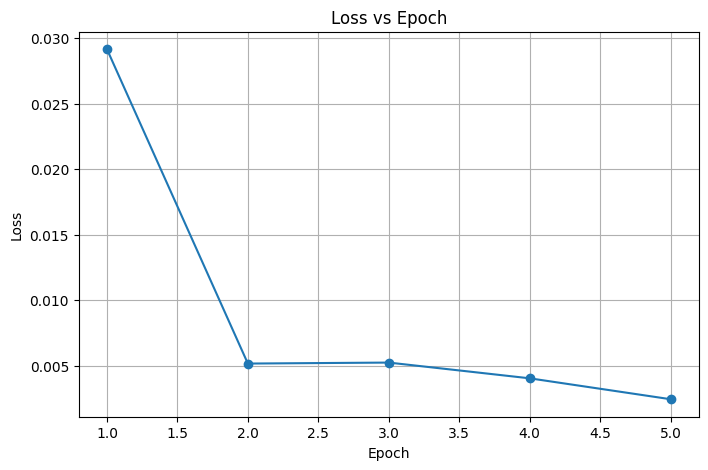

Training complete! Model saved.


In [51]:
# Run training
loss_vs_epoch = train()

In [52]:
loss_vs_epoch

[(1, 0.029165693560334882),
 (2, 0.005179069641535622),
 (3, 0.005254401967821765),
 (4, 0.004053341981220778),
 (5, 0.0024579264631947543)]

### Run 1 - [Batch 100 | Epoch 10]

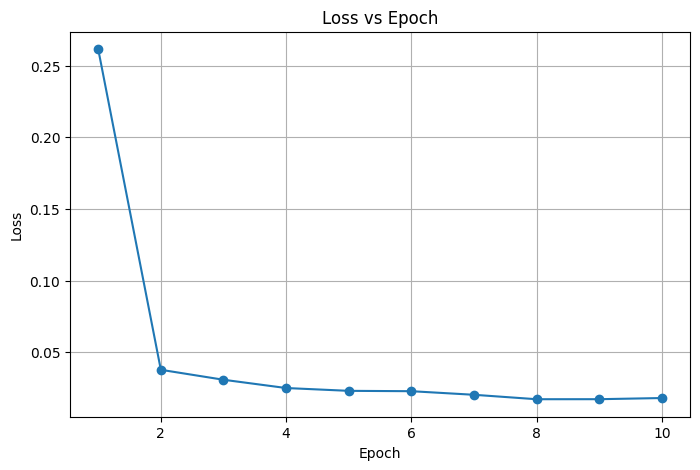

Training complete! Model saved.


In [39]:
# Run training
loss_vs_epoch = train()

In [40]:
loss_vs_epoch

[(1, 0.2615201030577342),
 (2, 0.03765817931348301),
 (3, 0.030705717268837505),
 (4, 0.02492831622710429),
 (5, 0.022959943975782),
 (6, 0.022711970008831156),
 (7, 0.020206949426736457),
 (8, 0.01710822087283392),
 (9, 0.017128966294273913),
 (10, 0.01793680332056864)]

### Run 2 - [Batch 70 | Epoch 30]

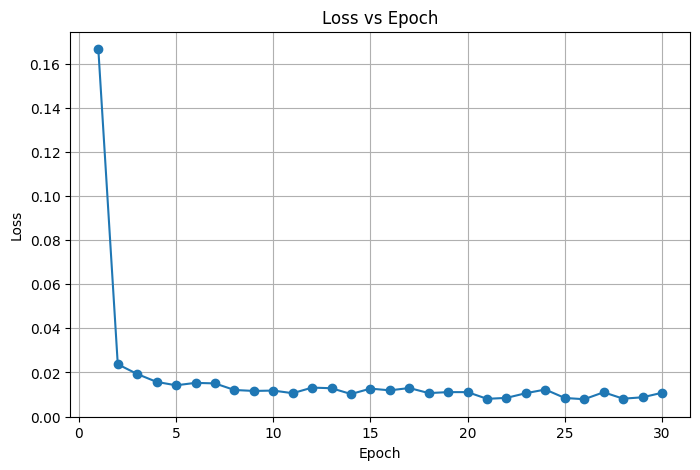

Training complete! Model saved.


In [32]:
# Run training
loss_vs_epoch = train()

In [33]:
loss_vs_epoch

[(1, 0.16650642693374243),
 (2, 0.023703856543653597),
 (3, 0.019290991616829976),
 (4, 0.015714569304383093),
 (5, 0.014170082272188264),
 (6, 0.015276086573899424),
 (7, 0.015030878156490655),
 (8, 0.01205358789223483),
 (9, 0.011612369555099946),
 (10, 0.01178741688599368),
 (11, 0.010591488264469524),
 (12, 0.013127339512535955),
 (13, 0.012837608721722864),
 (14, 0.010216109146328516),
 (15, 0.012668849712916477),
 (16, 0.011886368653642298),
 (17, 0.012937217138873382),
 (18, 0.01064085554315756),
 (19, 0.01108638220811973),
 (20, 0.011072986085911013),
 (21, 0.008039472934442684),
 (22, 0.00846657769851213),
 (23, 0.010604272673983853),
 (24, 0.012250919474616363),
 (25, 0.008429559563795673),
 (26, 0.007861794448325458),
 (27, 0.011016238446769668),
 (28, 0.008108529191211624),
 (29, 0.008733230152155541),
 (30, 0.010776781176376725)]

# Evaluation

In [34]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load model
model = SentenceEncoder(MODEL_NAME).to(DEVICE)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
# model.eval()

<All keys matched successfully>

In [35]:
tokenized_yaras = tokenizer(yaras, return_tensors="pt", padding=True, max_length=MAX_LEN, truncation=True)
tokenized_ctis = tokenizer(ctis, return_tensors="pt", padding=True, max_length=MAX_LEN, truncation=True)

In [36]:
tokenized_yaras['input_ids'].shape, tokenized_yaras['attention_mask'].shape

(torch.Size([10, 512]), torch.Size([10, 512]))

In [37]:
input_ids_yaras = tokenized_yaras["input_ids"].to(DEVICE)
attention_mask_yaras = tokenized_yaras["attention_mask"].to(DEVICE)
input_ids_ctis = tokenized_ctis["input_ids"].to(DEVICE)
attention_mask_ctis = tokenized_ctis["attention_mask"].to(DEVICE)   

In [38]:
emb_yaras = model(input_ids_yaras, attention_mask_yaras)
emb_ctis = model(input_ids_ctis, attention_mask_ctis)

In [39]:
emb_yaras.shape, emb_ctis.shape

(torch.Size([10, 384]), torch.Size([10, 384]))

In [40]:
# Step 2: Compute dot product matrix [num_desc x num_rules]
dot_product_matrix = torch.matmul(emb_ctis, emb_yaras.T)

# Step 3: Apply softmax along rules axis (dim=1), to get attention weights from each description to all rules
attention_weights = F.softmax(dot_product_matrix, dim=1).detach().cpu().numpy()

# Plot Attention

### Run 0 [Batch 16 | Epoch 5]

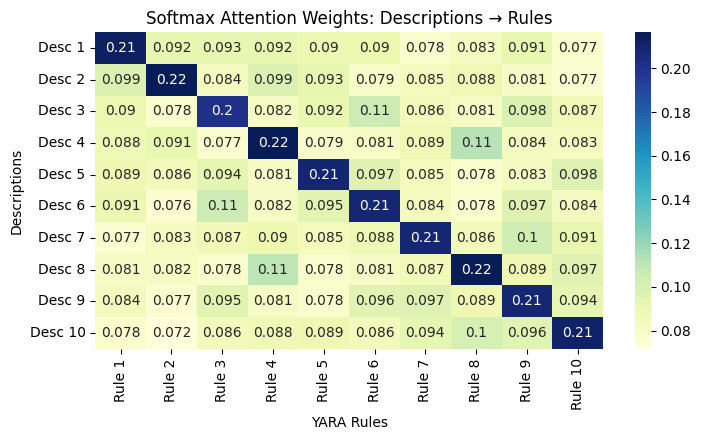

In [60]:
# Step 4: Plot attention heatmap
plt.figure(figsize=(7.5, 4.5))
sns.heatmap(attention_weights, annot=True, cmap="YlGnBu", 
            xticklabels=[f"Rule {i+1}" for i in range(len(yaras))], 
            yticklabels=[f"Desc {i+1}" for i in range(len(ctis))])
plt.title("Softmax Attention Weights: Descriptions → Rules")
plt.xlabel("YARA Rules")
plt.ylabel("Descriptions")
plt.tight_layout()
plt.show()

### Run 1 - [Batch 100 | Epoch 10]

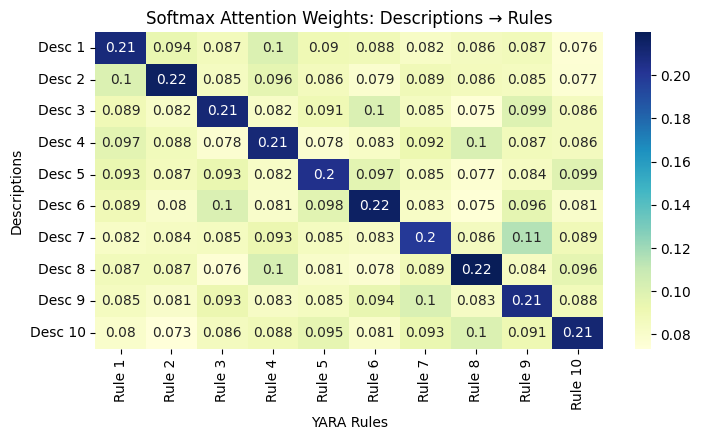

In [48]:
# Step 4: Plot attention heatmap
plt.figure(figsize=(7.5, 4.5))
sns.heatmap(attention_weights, annot=True, cmap="YlGnBu", 
            xticklabels=[f"Rule {i+1}" for i in range(len(yaras))], 
            yticklabels=[f"Desc {i+1}" for i in range(len(ctis))])
plt.title("Softmax Attention Weights: Descriptions → Rules")
plt.xlabel("YARA Rules")
plt.ylabel("Descriptions")
plt.tight_layout()
plt.show()

### Run 2 - [Batch 70 | Epoch 30]

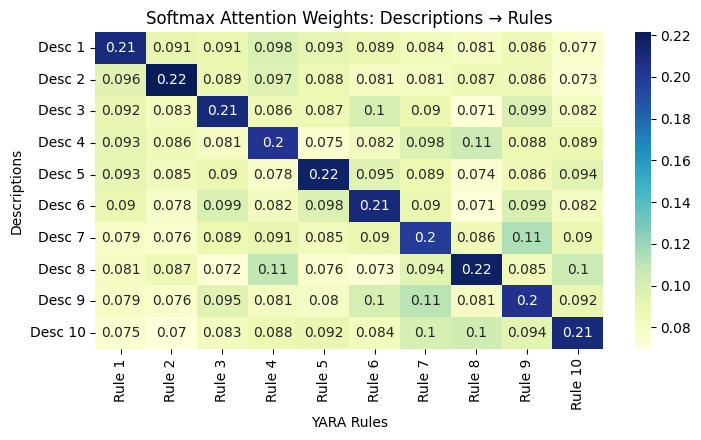

In [41]:
# Step 4: Plot attention heatmap
plt.figure(figsize=(7.5, 4.5))
sns.heatmap(attention_weights, annot=True, cmap="YlGnBu", 
            xticklabels=[f"Rule {i+1}" for i in range(len(yaras))], 
            yticklabels=[f"Desc {i+1}" for i in range(len(ctis))])
plt.title("Softmax Attention Weights: Descriptions → Rules")
plt.xlabel("YARA Rules")
plt.ylabel("Descriptions")
plt.tight_layout()
plt.show()

# Semantic Evaluation

In [36]:
def compute_dot_product_matrix_batched(model, tokenizer, test_snorts, test_ctis, batch_size=64):
    # Tokenize snorts once (since all CTIs will be compared to them)
    tokenized_snorts = tokenizer(test_snorts, return_tensors="pt", padding=True, max_length=MAX_LEN, truncation=True)
    input_ids_snorts = tokenized_snorts["input_ids"].to(DEVICE)
    attention_mask_snorts = tokenized_snorts["attention_mask"].to(DEVICE)

    with torch.no_grad():
        emb_snorts = model(input_ids_snorts, attention_mask_snorts)  # (802, dim)
        emb_snorts = emb_snorts.detach()

    # Prepare output tensor for all dot products
    num_ctis = len(test_ctis)
    dot_product_matrix = []

    for i in range(0, num_ctis, batch_size):
        batch_ctis = test_ctis[i:i + batch_size]
        tokenized_ctis = tokenizer(batch_ctis, return_tensors="pt", padding=True, max_length=MAX_LEN, truncation=True)
        input_ids_ctis = tokenized_ctis["input_ids"].to(DEVICE)
        attention_mask_ctis = tokenized_ctis["attention_mask"].to(DEVICE)

        with torch.no_grad():
            emb_ctis = model(input_ids_ctis, attention_mask_ctis)  # (B, dim)
            dot_product_batch = torch.matmul(emb_ctis, emb_snorts.T)  # (B, 802)
            dot_product_matrix.append(dot_product_batch.cpu())

        # Cleanup
        del input_ids_ctis, attention_mask_ctis, emb_ctis, dot_product_batch
        torch.cuda.empty_cache()

    # Concatenate batches into full matrix
    dot_product_matrix = torch.cat(dot_product_matrix, dim=0)  # (802, 802)
    return dot_product_matrix


In [37]:
import torch
from sklearn.metrics import f1_score
import numpy as np

def evaluate_similarity_with_auto_threshold(dot_product_matrix: torch.Tensor):
    """
    Evaluates diagonal recall and best F1-score based on thresholded sigmoid scores.

    Args:
        dot_product_matrix (torch.Tensor): Square similarity matrix (N x N)

    Returns:
        dict: {
            'recall_diag': float,
            'f1_best': float,
            'best_threshold': float,
            'sigmoid_min': float,
            'sigmoid_max': float,
        }
    """
    assert dot_product_matrix.ndim == 2 and dot_product_matrix.shape[0] == dot_product_matrix.shape[1], \
        "Input must be a square matrix."

    N = dot_product_matrix.shape[0]
    sigmoid_scores = torch.sigmoid(dot_product_matrix)

    # Diagonal recall
    correct = 0
    for i in range(N):
        if torch.argmax(dot_product_matrix[i]).item() == i:
            correct += 1
    recall_diag = correct / N

    # Prepare binary labels
    labels = []
    flat_scores = []
    for i in range(N):
        for j in range(N):
            labels.append(1 if i == j else 0)
            flat_scores.append(sigmoid_scores[i, j].item())

    # Search best threshold for max F1
    thresholds = np.linspace(min(flat_scores), max(flat_scores), num=100)
    best_f1 = 0.0
    best_threshold = 0.0

    for t in thresholds:
        preds = [1 if s >= t else 0 for s in flat_scores]
        f1 = f1_score(labels, preds, zero_division=0)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t

    return {
        "recall_diag": recall_diag,
        "f1_best": best_f1,
        "best_threshold": best_threshold,
        "sigmoid_min": min(flat_scores),
        "sigmoid_max": max(flat_scores)
    }

In [38]:
test_snorts = [i[0] for i in test_pairs]
test_ctis = [i[1] for i in test_pairs]

In [39]:
len(test_snorts), len(test_ctis)

(916, 916)

## Pre-trained

In [40]:
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load model
model = SentenceEncoder(MODEL_NAME).to(DEVICE)

In [41]:
dot_product_matrix_test = compute_dot_product_matrix_batched(
    model=model,
    tokenizer=tokenizer,
    test_snorts=test_snorts,
    test_ctis=test_ctis,
    batch_size=256
)

results = evaluate_similarity_with_auto_threshold(dot_product_matrix_test)

for k, v in results.items():
    print(f"{k}: {v:.4f}")

recall_diag: 0.7991
f1_best: 0.5603
best_threshold: 0.7175
sigmoid_min: 0.6194
sigmoid_max: 0.7261


## Run - 0

In [42]:
RUN = 0
FINE_TUNED_MODEL_NAME = "all-MiniLM-L6-v2"
MODEL_NAME = f"/data/common/models/sentence-transformers/{FINE_TUNED_MODEL_NAME}"
FINE_TUNED_MODEL_STATE_NAME = f"contrastive_encoder_r{RUN}.pt"
MODEL_SAVE_PATH = os.path.join(project_base_path, f"script/fine_tuning/bi-encoder/snort/{FINE_TUNED_MODEL_NAME}/{FINE_TUNED_MODEL_STATE_NAME}")


# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load model
model = SentenceEncoder(MODEL_NAME).to(DEVICE)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))

<All keys matched successfully>

In [44]:
dot_product_matrix_test = compute_dot_product_matrix_batched(
    model=model,
    tokenizer=tokenizer,
    test_snorts=test_snorts,
    test_ctis=test_ctis,
    batch_size=256
)

results = evaluate_similarity_with_auto_threshold(dot_product_matrix_test)

for k, v in results.items():
    print(f"{k}: {v:.4f}")

recall_diag: 0.7347
f1_best: 0.6006
best_threshold: 0.6517
sigmoid_min: 0.4629
sigmoid_max: 0.7225


## Run - 1

In [45]:
RUN = 1
FINE_TUNED_MODEL_NAME = "all-MiniLM-L6-v2"
MODEL_NAME = f"/data/common/models/sentence-transformers/{FINE_TUNED_MODEL_NAME}"
FINE_TUNED_MODEL_STATE_NAME = f"contrastive_encoder_r{RUN}.pt"
MODEL_SAVE_PATH = os.path.join(project_base_path, f"script/fine_tuning/bi-encoder/snort/{FINE_TUNED_MODEL_NAME}/{FINE_TUNED_MODEL_STATE_NAME}")


# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load model
model = SentenceEncoder(MODEL_NAME).to(DEVICE)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))

<All keys matched successfully>

In [46]:
dot_product_matrix_test = compute_dot_product_matrix_batched(
    model=model,
    tokenizer=tokenizer,
    test_snorts=test_snorts,
    test_ctis=test_ctis,
    batch_size=256
)

results = evaluate_similarity_with_auto_threshold(dot_product_matrix_test)

for k, v in results.items():
    print(f"{k}: {v:.4f}")

recall_diag: 0.8068
f1_best: 0.6694
best_threshold: 0.6465
sigmoid_min: 0.4530
sigmoid_max: 0.7190


## Run - 2

In [47]:
RUN = 2
FINE_TUNED_MODEL_NAME = "all-MiniLM-L6-v2"
MODEL_NAME = f"/data/common/models/sentence-transformers/{FINE_TUNED_MODEL_NAME}"
FINE_TUNED_MODEL_STATE_NAME = f"contrastive_encoder_r{RUN}.pt"
MODEL_SAVE_PATH = os.path.join(project_base_path, f"script/fine_tuning/bi-encoder/snort/{FINE_TUNED_MODEL_NAME}/{FINE_TUNED_MODEL_STATE_NAME}")


# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

# Load model
model = SentenceEncoder(MODEL_NAME).to(DEVICE)
model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))

<All keys matched successfully>

In [48]:
dot_product_matrix_test = compute_dot_product_matrix_batched(
    model=model,
    tokenizer=tokenizer,
    test_snorts=test_snorts,
    test_ctis=test_ctis,
    batch_size=256
)

results = evaluate_similarity_with_auto_threshold(dot_product_matrix_test)

for k, v in results.items():
    print(f"{k}: {v:.4f}")

recall_diag: 0.8472
f1_best: 0.6947
best_threshold: 0.6421
sigmoid_min: 0.4534
sigmoid_max: 0.7203
